This code is to calculate the window diagnostics for Wind and Precipitation from WRF output. And compare with the wrfdly output. This is to try and validate the output from WRF.

## Data needed
* wrfout: output at each time step including t0. (i.e. `write_hist_at_0h_rst = .true.`)
* wrfdly: output for the diagnostics every hour (i.e. `auxhist7_interval = 60`). Must cover the same time period as the wrfout file.

In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import numpy as np

# Paths to data and averaging windows

In [2]:
# Paths
data_path=Path("/g/data/w35/ccc561/WRF/wrfdiags_testing")
wrfout_file="wrfout_d01_2016-10-06_00:00:00"
wrfdly_file="wrfdly_d01_2016-10-06_00:00:00"

# Time windows to calculate values on
Window_ave = pd.to_timedelta(["00:05:00","00:10:00","00:20:00","00:30:00","00:60:00"])

# Functions
### Functions to wrangle the input data

In [3]:
def get_windspeed(out_d01):
    U10_wrfout = out_d01["U10"][1:]
    V10_wrfout = out_d01["V10"][1:]
    Speed = xr.ufuncs.sqrt(U10_wrfout**2+V10_wrfout**2)
    Speed.attrs["units"]=U10_wrfout.attrs["units"]
    Speed.attrs["description"]="Wind speed at 10m"
    Speed = Speed.rename("Wind speed")
    
    return Speed

In [4]:
def get_distance(Speed, timestep):
    Wind_dist = Speed * timestep/np.timedelta64(1,"s")
    Wind_dist.attrs["units"]="m"
    Wind_dist.attrs["description"]="Distance travelled by wind"
    Wind_dist = Wind_dist.rename("Wind distance")
    
    return Wind_dist

In [5]:
def convert_to_hour_coord(diag):
    hour = diag["Time"].dt.hour
    diag_hour = diag.rename({"Time":"hour"})
    diag_hour = diag_hour.assign_coords({"hour":('hour',hour.data)})
    
    return diag_hour

### Functions to get the average window values

In [6]:
def get_weights_per_window(ntstep_in_window):
    '''Get the weigths for the weighted average.
    If ntstep_in_window has no decimal part:
        the number of weights is the integer part of ntstep_in_window and all weights are 1.
    If ntstep_in_window has a decimal part:
        we need one more weight compared to the previous case. This weight is equal to the decimal part.
        
    ntstep_in_window: list of floats, number of timesteps in each averaging window'''
    
    weights=[]
    for ww in ntstep_in_window:
        int_part = np.floor(ww).astype(np.int_)
        decimal_last_weight = ww - int_part
        nweights = int_part + (decimal_last_weight > 0)
        # All weights are 1 but the last
        window_weights=[1] * int_part
        window_weights.append(decimal_last_weight)
        # Remove the last weight if there is no decimal part
        window_weights = window_weights[:nweights]
        # Convert to DataArray
        window_weights = xr.DataArray(window_weights,dims="weights",name="weights")
        weights.append(window_weights)

    return weights

In [7]:
def get_rolling_windows(Dist, rolling_window):
    '''Construct the rolling windows and remove the first one that contains NaN'''
    # Construct the windows
    Wind_dist_window=Dist.rolling(Time=rolling_window).construct(window_dim="weights")
    # First window starts with NaN
    Wind_dist_window=Wind_dist_window[1:]
    
    # Need to change the XTIME labels. Xarray gives the labels at the end or the centre of the rolling window but we need the data at the start.
    XTIME = Wind_dist_window["XTIME"]
    XTIME_ts = XTIME[1]-XTIME[0]
    XTIME = XTIME - XTIME_ts
    
    Wind_dist_window = Wind_dist_window.assign_coords({"XTIME":('Time',XTIME.data)})
    
    return Wind_dist_window

In [8]:
def window_weighted_average(data_on_window, weights, average_window):
    '''Get the average quantity, per second,  for each rolling window.
    We want the time at the end of each rolling window so we add 1 hour to the time coordinate XTIME
    
    data_on_window: DataArray with a "weights" dimension, output from get_rolling_windows
    weights: list of floats, weights to apply to each value of data_on_window along the "weights" dimension
    average_window: Pandas timedelta, length of the window in time'''

    data_window_weighted=data_on_window.weighted(weights).sum(dim="weights")/average_window.seconds
    
    onehour = pd.to_timedelta(["01:00:00"])
    data_window_weighted.coords["XTIME"] = data_window_weighted.coords["XTIME"] + onehour[0]
    
    return data_window_weighted


In [9]:
def window_valuemax(data_weighted):
    '''Get the max of the average quantity over rolling windows within 1 hour.
    The time of data_weighted is assumed to be the start of the 
    
    data_weighted: DataArray with a "XTIME" coordinate for the time and a "Time" dimension'''

    # We want only to look at the first day before grouping by hour
    Day1 = Wind_window_weighted.XTIME.dt.day[0]
    print(Day1)
    wind_day1 = Wind_window_weighted.where(Wind_window_weighted.XTIME.dt.day == Day1,drop=True)
    wind_window_max = wind_day1.groupby("XTIME.hour").max(dim="Time") #Wind_window_weighted.groupby("XTIME.hour").max(dim="Time")
    wind_window_max = wind_window_max.rename("wind_window_max")
    
    return wind_window_max

In [10]:
def index_of_max(val_array):
    '''Replaces argmax which does not exist for DataArrayGroupBy objects'''
    ind_max = val_array.argmax(dim="Time")
    return ind_max

In [11]:
def window_timeofmax(data_weighted):
    '''Get the time of the max of the average quantity over rolling windows within 1 hour
    The time of the max is given at the beginning of the rolling window.
    
    data_weighted: DataArray with a "XTIME" coordinate for the time and a "Time" dimension'''

    time_window_max = Wind_window_weighted.groupby("XTIME.hour").apply(index_of_max)
    time_window_max = time_window_max.rename("time_window_max")
    
    return time_window_max

# Start program
## Read in wrfout and wrfdly

In [12]:
# Read in data for domain 1
out_d01=xr.open_dataset(data_path/wrfout_file)
dly_d01=xr.open_dataset(data_path/wrfdly_file)

# Decode the times and add as the XTIME coordinate to the dataset
times = [tt.item().decode() for tt in dly_d01["Times"]]
dly_time=xr.DataArray(pd.to_datetime(times,format="%Y-%m-%d_%H:%M:%S"),dims=["Time"],name="Time",coords={})
dly_d01=dly_d01.assign_coords({"Time":("Time",dly_time.data)})

## Calculate timestep from wrfout data

In [13]:
# wrfout timestep. It should be the time step of the run
timestep = out_d01["XTIME"][1]-out_d01["XTIME"][0]
timestep = pd.to_timedelta(timestep.item())

## Get the diagnostic and time from wrfdly. And the distance travelled by the wind from wrfout.

### Select the first point only
The first time step of the diagnostics and the wrfout is the initial conditions so we need to remove it (`Time=slice(1,-1)`)

In [14]:
UV10MAX5=dly_d01["UV10MAX5"].isel(south_north=0,west_east=0,Time=slice(1,-1))
TUV10MAX5 = dly_d01["TUV10MAX5"].isel(south_north=0,west_east=0,Time=slice(1,-1))

In [15]:
Speed = get_windspeed(out_d01).isel(south_north=0, west_east=0)#,Time=slice(1,-1))
Dist  = get_distance(Speed, timestep)  # Speed is already selected, no need to select Dist as well.

## Calculate the average windows and weights for each window
We need to know how many timesteps we need to average over for each window. For this, we divide the Window period by the timestep, in float, then take the `ceil()` to round up.

In [17]:
# Number of time steps in in each window.
ntstep_in_window = Window_ave/timestep
rolling_windows = [np.ceil(nt).astype(np.int_) for nt in ntstep_in_window]

For each window, define a scaling factor to apply to each time step for the weighting average.

For example, if ntstep_in_window = 1.6666, we need to average 2 timesteps with the weights (1, 0.66666)

* If ntstep_in_window has no decimal part, the number of weights is the integer part of ntstep_in_window and all weights are 1.
* If ntstep_in_window has a decimal part, we need one more weight compared to the previous case. This weight is equal to the decimal part.

In [18]:
weights = get_weights_per_window(ntstep_in_window)

## Get the frequency of the wrfdly outputs

## Test on the first window
1. Construct the windows for the distance
2. Add the weights and calculate the sum over each window
3. For each hour, get the max. value and the time of the max.

In [19]:
Wind_dist_window = get_rolling_windows(Dist, rolling_windows[0])

In [20]:
Wind_window_weighted = window_weighted_average(Wind_dist_window, weights[0], Window_ave[0])
wind_window_max = window_valuemax(Wind_window_weighted)
time_window_max = window_timeofmax(Wind_window_weighted)

<xarray.DataArray 'day' ()>
array(6)
Coordinates:
    XLAT     float32 15.26
    XLONG    float32 -87.48
    XTIME    datetime64[ns] 2016-10-06T01:02:00


We need to change the Time coordinate of UV10MAX5 and TUV10MAX5 to be just the hour as it is the time coordinate of the window arrays. First, we restrict the diagnostic data to 1 day only.

In [21]:
UV10MAX5_1day = UV10MAX5.where(UV10MAX5.Time.dt.day==UV10MAX5.Time.dt.day[0],drop=True)
UV10MAX5_hour = convert_to_hour_coord(UV10MAX5_1day)

In [22]:
ds_comp = xr.merge([wind_window_max, UV10MAX5_hour], join="inner")

In [23]:
np.allclose(ds_comp['wind_window_max'].data, ds_comp['UV10MAX5'].data)

True

In [24]:
Wind_window_weighted.where((Wind_window_weighted.XTIME.dt.day == 6)& 
                           (Wind_window_weighted.XTIME.dt.hour == 1),drop=True)

<xarray.DataArray 'Wind distance' (Time: 29)>
array([0.84463601, 1.48027208, 1.59162436, 1.60128095, 1.60014381,
       1.59801064, 1.59574883, 1.59346516, 1.59118195, 1.58888667,
       1.58660078, 1.58430145, 1.58197756, 1.57965591, 1.57733061,
       1.57732539, 1.57972894, 1.58221657, 1.580057  , 1.57769227,
       1.57527633, 1.57282865, 1.57034967, 1.56618617, 1.55849714,
       1.54710722, 1.53534515, 1.52359593, 1.51185982])
Coordinates:
    XLAT     (Time) float32 15.26 15.26 15.26 15.26 ... 15.26 15.26 15.26 15.26
    XLONG    (Time) float32 -87.48 -87.48 -87.48 -87.48 ... -87.48 -87.48 -87.48
    XTIME    (Time) datetime64[ns] 2016-10-06T01:02:00 ... 2016-10-06T01:58:00
Dimensions without coordinates: Time

In [25]:
Wind_dist_window[:10,:]

<xarray.DataArray 'Wind distance' (Time: 10, weights: 3)>
array([[         nan, 158.79222393, 189.19715881],
       [158.79222393, 189.19715881, 192.18448162],
       [189.19715881, 192.18448162, 192.21133232],
       [192.18448162, 192.21133232, 191.97694302],
       [192.21133232, 191.97694302, 191.70973778],
       [191.97694302, 191.70973778, 191.43301964],
       [191.70973778, 191.43301964, 191.16378307],
       [191.43301964, 191.16378307, 190.88549137],
       [191.16378307, 190.88549137, 190.61061859],
       [190.88549137, 190.61061859, 190.33977985]])
Coordinates:
    XLAT     (Time) float32 15.26 15.26 15.26 15.26 ... 15.26 15.26 15.26 15.26
    XLONG    (Time) float32 -87.48 -87.48 -87.48 -87.48 ... -87.48 -87.48 -87.48
    XTIME    (Time) datetime64[ns] 2016-10-06T00:02:00 ... 2016-10-06T00:20:00
Dimensions without coordinates: Time, weights
Attributes:
    units:        m
    description:  Distance travelled by wind

In [26]:
dly_d01["UV10MAX5"].isel(south_north=0,west_east=0)

<xarray.DataArray 'UV10MAX5' (Time: 11)>
array([0.      , 1.601281, 1.500137, 1.156724, 0.842519, 0.604902, 0.72011 ,
       0.734559, 0.602549, 0.487883, 0.430629], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2016-10-06 ... 2016-10-06T10:00:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  MAXIMUM 5 MIN. WIND SPEED
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [27]:
dly_d01["TUV10MAX5"].isel(south_north=0,west_east=0)

<xarray.DataArray 'TUV10MAX5' (Time: 11)>
array([ 0.      ,  9.      ,  1.      ,  1.      ,  1.      ,  1.      ,
       59.000004,  5.      ,  1.      ,  1.      , 59.000004], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2016-10-06 ... 2016-10-06T10:00:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TIME OF MAXIMUM 5 MIN. WIND SPEED
    units:        minute
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [28]:
wind_window_max

<xarray.DataArray 'wind_window_max' (hour: 10)>
array([1.60128095, 1.50013721, 1.15672362, 0.84251903, 0.60490161,
       0.72011017, 0.73455888, 0.60254855, 0.48788263, 0.43062871])
Coordinates:
  * hour     (hour) int64 1 2 3 4 5 6 7 8 9 10

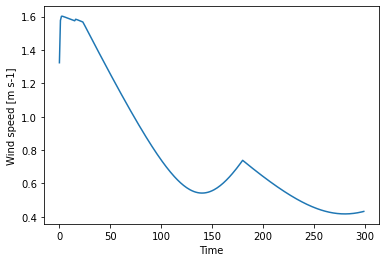

In [29]:
Speed.plot()

In [30]:
Dist[0:3]

<xarray.DataArray 'Wind distance' (Time: 3)>
array([158.79222393, 189.19715881, 192.18448162])
Coordinates:
    XLAT     (Time) float32 15.26 15.26 15.26
    XLONG    (Time) float32 -87.48 -87.48 -87.48
    XTIME    (Time) datetime64[ns] 2016-10-06T00:02:00 ... 2016-10-06T00:06:00
Dimensions without coordinates: Time
Attributes:
    units:        m
    description:  Distance travelled by wind

In [31]:
timestep

Timedelta('0 days 00:02:00')

In [32]:
tt=(158.79222393+189.19715881+192.18448162/2.)/(5.*60.)
tt

1.4802720785